We propose an implementation of the SPICE (Self-supervised Pitch Estimation) model according to the specifications of the scientific paper published by Google researchers (Submitted October 25, 2019 ( v1 ), last revised September 4, 2020 ( v2 )). September 2020 ( version v2)). According to our reseaches (we had done a bibliographical review on existing pitch estimation methods), SPICE model is the current state of the art in the field of pitch estimation.

# Motivations
We acknowledge the fact that obtaining ground truth annotations at the required temporal and frequency resolution is
 a particularly daunting task. Therefore, SPICE is designed to adopt a self-supervised learning technique, which is able to estimate
pitch without any form of supervision.

### The key observation is that pitch shift maps to a simple translation when the audio signal is analysed through the lens of the constant-Q transform (CQT).

# Network Architecture
Our network architecture consists of a convolutional
encoder which produces a single scalar embedding. We aim at
learning a model that linearly maps this scalar value to pitch,
when the latter is expressed in a logarithmic scale, i.e., in units
of semitones of an equally tempered chromatic scale.

To do this, we feed two versions of the same signal to the encoder,
one being a pitch shifted version of the other by a random but
known amount. Then, we devise a loss function that forces the
difference between the scalar embeddings to be proportional to
the known difference in pitch. Upon convergence, the model is
able to estimate relative pitch, solely relying on self-supervision.
In order to translate relative pitch to absolute pitch, we apply
a simple calibration step, which can be done using a small
synthetically generated dataset. Therefore, the model is able to
produce absolute pitch without having access to any manually
labelled dataset.


In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import librosa
from librosa import display
from pathlib import Path
from librosa.core import cqt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
import time



In [ ]:
print(tf.__version__)


2.8.0


In [ ]:
audio_expl = Path("C:/Users/hp/anaconda3/imitations/takwir_basit/original_filtered.wav")

In [ ]:
y, sr = librosa.load(audio_expl,sr=16000)

In [ ]:
print(y.shape)

(608000,)


In [ ]:
print(sr)

16000


In [ ]:
duration = len(y)/sr
print(duration)

38.0


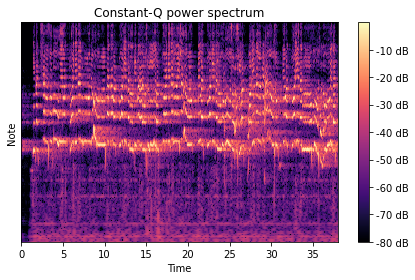

In [ ]:
# plotting CQT spectrum
C = np.abs(librosa.cqt(y, sr=sr,hop_length=512,n_bins=190,bins_per_octave=24))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                               sr=16000, x_axis='time', y_axis='cqt_note', ax=ax)
ax.set_title('Constant-Q power spectrum')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.title('Constant-Q power spectrum')
plt.tight_layout()
plt.show()


In [ ]:
C.shape
c_transp =C.transpose()
len(c_transp)

1188

In [ ]:
# x_frames_1 = []
# x_frames_2 = []
# pretex_label = []
# for frame in c_transp[0:10] :

#                 k1 = np.random.randint(kmin,kmax+1)
#                 k2 = np.random.randint(kmin,kmax+1)
#                 λk1 =(fbase)*2**(k1/Q)
#                 λk2 =(fbase)*2**(k2/Q)
#                 α = λk2/λk1
#                 delta_k = Q*np.log2(α)
#                 p =σ*delta_k
#                 pretex_label.append(p)
#                 x1 =frame[k1 : k1 + F].reshape(1,128,1)
#                 #x1 = np.reshape(x1,(1,128,1)).astype('float32')
#                 x_frames_1.append(x1)
#                 x2 =frame[k2 : k2 + F].reshape(1,128,1)
#                 #x2 = np.reshape(x2,(1,128,1)).astype('float32')
#                 x_frames_2.append(x2)
# x_frames_1 = np.array(x_frames_1).astype("float32")
# x_frames_2 = np.array(x_frames_2).astype("float32")
# x_recons_1 = np.ones(x_frames_1.shape).astype("float32")
# x_recons_2 = np.ones(x_frames_2.shape).astype("float32")
# #pretex_label = np.array(pretex_label).astype("float32")
# x_recons_2.shape

In [ ]:
# print(list_frame[0].shape, list_frame[0].dtype)
# print(pretex_label.shape,pretex_label.dtype)

In [ ]:
#data_sim_folder = Path("C:/Users/hp/anaconda3/test_imits/")

# METHODS
The proposed pitch estimation model receives as input an audio track of arbitrary length and produces as output
a time series of estimated pitch frequencies, together with an indication of the confidence of the estimates. The latter is used to discriminate between unvoiced frames, in which pitch is not well defined, and voiced frames.

![spice_model_architecture.PNG](attachment:spice_model_architecture.PNG)

### Constantes
Q denotes the number of filters per octave,

λk = fbase*2^k/Q , k ∈ 0, . . . , Fmax − 1,
where fbase is the frequency of the lowest frequency bin and
Fmax is the number of CQT bins.

Each filter is centered at frequency λk and has a bandwidth
equal to λk/Q.

Therefore, for the class of locally periodic
signals that can be represented as a wavelet expansion, a
translation of ∆k bins in the CQT domain is related to a
pitch-shift by a factor α
->
∆k = k2 − k1 = Q · log2 α

where α = λk2/λk1


In [ ]:
# Constantes & model parameters
Q = 24 # Bins_per_octave
Fmax = 190 # n_bins
F = 128 # number of CQT bins in the slice
fbase = 32.70
fmin = fbase*2**(0/Q) # (fbase) equal to the frequency of the note C1, i.e. 32.70 Hz
fmax = fbase*2**((Fmax-1)/Q)
σ = 1 /(Q*np.log2(fmax/fmin))
τ = 0.25*σ # Huber treshold
w_pitch = 10**4 # loss weigth
w_recons = 1 # loss weigth
L = 6 # number of layers
kmin = 0
kmax = 8
batch_size = 1

In [ ]:
fmax # cover the range of frequency up to Nyquist.

7676.424246474944

# Audio frontend
The proposed model architecture is illustrated in Figure above.
Given an input track, the audio frontend computes the absolute
value of the CQT, which is represented as a real-valued matrix
X of size T×Fmax, where T depends on the selected hop length and the windowing function.
### Remark:
T is equal to the batch size during training .

# Encoder
The encoder receives as input a 128-dimensional vector
corresponding to a sliced CQT frame and produces as output
two scalars representing, respectively, pitch and confidence.
The model architecture consists of L = 6 convolutional layers.
We use filters of size 3 and stride equal to 1. The number
of channels is equal to d·[1, 2, 4, 8, 8, 8], where d = 64 for
the encoder and d = 32 for the decoder. Each convolution
is followed by batch normalization and a ReLU non-linearity.
Max-pooling of size 3 and stride 2 is applied at the output
of each layer. Hence, after flattening the output of the last
convolutional layer we obtain an embedding of size 1024
elements.

In [ ]:
# # Encoder
# encoder_input = keras.Input(shape=(128,1), name="CQT_matrix") #
# x = layers.Conv1D(64, 3, activation="relu")(encoder_input)
# x = layers.BatchNormalization()(x)
# #x = layers.MaxPooling1D(3,2)(x)
# x = layers.Conv1D(128, 3, activation="relu")(x)
# x = layers.BatchNormalization()(x)
# x = layers.MaxPooling1D(3,2)(x)
# x = layers.Conv1D(256, 3, activation="relu")(x)
# x = layers.BatchNormalization()(x)
# x = layers.MaxPooling1D(3,2)(x)
# x = layers.Conv1D(512, 3, activation="relu")(x)
# x = layers.BatchNormalization()(x)
# #x = layers.MaxPooling1D(3,2)(x)
# x = layers.Conv1D(512, 3, activation="relu")(x)
# x = layers.BatchNormalization()(x)
# x = layers.MaxPooling1D(3,2)(x)
# x = layers.Conv1D(512, 3, activation="relu")(x)
# x = layers.BatchNormalization()(x)
# x = layers.MaxPooling1D(3,2)(x)
# x = layers.MaxPooling1D(3,1)(x)
# # shared layer conv_base
# conv_base = layers.Flatten()(x)

# # pitch head consist of 2 dense layers
# p = layers.Dense(64)(conv_base)
# pitch_pred = layers.Dense(1, activation="sigmoid", name="pitch_head")(p)

# # confidence head
# #conf_pred = layers.Dense(1, activation="sigmoid", name="confidence_head")(conv_base)

# encoder= keras.Model(inputs = encoder_input, outputs = [pitch_pred], name="encoder")
# encoder.summary()

In [ ]:
# Encoder
encoder_input = keras.Input(shape=(1,128,1), name="CQT_matrix")
x = layers.Conv2D(64, (1,3),strides=(1,1),padding='same')(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation ='relu')(x)
x = layers.MaxPooling2D((1,2),(1,2))(x)
x = layers.Conv2D(128, (1,3),strides=(1,1),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation ='relu')(x)
x = layers.MaxPooling2D((1,2),(1,2))(x)
x = layers.Conv2D(256, (1,3),strides=(1,1),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation ='relu')(x)
x = layers.MaxPooling2D((1,2),(1,2))(x)
x = layers.Conv2D(512,(1,3), strides=(1,1),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation ='relu')(x)
x = layers.MaxPooling2D((1,2),(1,2))(x)
x = layers.Conv2D(512,(1,3), strides=(1,1),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation ='relu')(x)
x = layers.MaxPooling2D((1,2),(1,2))(x)
x = layers.Conv2D(512,(1,3), strides=(1,1),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation ='relu')(x)
x = layers.MaxPooling2D((1,2),(1,2))(x)
# shared layer conv_base
conv_base = layers.Flatten()(x)

# pitch head consist of 2 dense layers
p = layers.Dense(64)(conv_base)
p = layers.Activation(activation ='relu')(p)
pitch_pred = layers.Dense(1,activation="sigmoid", name="pitch_head")(p)

# confidence head
# conf_pred = layers.Dense(1,activation="sigmoid", name="confidence_head")(conv_base)

encoder= keras.Model(inputs = encoder_input, outputs = [pitch_pred], name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CQT_matrix (InputLayer)     [(None, 1, 128, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 1, 128, 64)        256       
                                                                 
 batch_normalization_12 (Bat  (None, 1, 128, 64)       256       
 chNormalization)                                                
                                                                 
 activation_13 (Activation)  (None, 1, 128, 64)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 1, 64, 64)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 1, 64, 128)        2470

In [ ]:
[print(i.shape, i.dtype) for i in encoder.inputs]
[print(o.shape, o.dtype) for o in encoder.outputs]
[print(l.name, l.input_shape, l.dtype) for l in encoder.layers]

(None, 1, 128, 1) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
CQT_matrix [(None, 1, 128, 1)] float32
conv2d_6 (None, 1, 128, 1) float32
batch_normalization_12 (None, 1, 128, 64) float32
activation_13 (None, 1, 128, 64) float32
max_pooling2d_6 (None, 1, 128, 64) float32
conv2d_7 (None, 1, 64, 64) float32
batch_normalization_13 (None, 1, 64, 128) float32
activation_14 (None, 1, 64, 128) float32
max_pooling2d_7 (None, 1, 64, 128) float32
conv2d_8 (None, 1, 32, 128) float32
batch_normalization_14 (None, 1, 32, 256) float32
activation_15 (None, 1, 32, 256) float32
max_pooling2d_8 (None, 1, 32, 256) float32
conv2d_9 (None, 1, 16, 256) float32
batch_normalization_15 (None, 1, 16, 512) float32
activation_16 (None, 1, 16, 512) float32
max_pooling2d_9 (None, 1, 16, 512) float32
conv2d_10 (None, 1, 8, 512) float32
batch_normalization_16 (None, 1, 8, 512) float32
activation_17 (None, 1, 8, 512) float32
max_pooling2d_10 (None, 1, 8, 512) float32
conv2d_11 (None, 1, 4, 512) float32
batch_normali

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

 # Decoder
 The decoder is
a neural network with L convolutional layers whose architecture
is the mirrored version of the encoder, with convolutions
replaced by transposed convolutions, which maps the scalar
value yi,t back to a vector with the same shape as the input
frame

In [ ]:
# decoder
decoder_input = keras.Input(shape=(1,), name="encoded_CQT")
x = layers.Reshape((1, 1, 1))(decoder_input)
x = layers.Conv2DTranspose(32, (1,3),strides=(1,1),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation ='relu')(x)
x = layers.UpSampling2D(size = (1,2))(x)
x = layers.Conv2DTranspose(64, (1,3), strides=(1,1),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation ='relu')(x)
x = layers.UpSampling2D(size = (1,2))(x)
x = layers.Conv2DTranspose(128, (1,3), strides=(1,1),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation ='relu')(x)
x = layers.UpSampling2D(size = (1,2))(x)
x = layers.Conv2DTranspose(256, (1,3), strides=(1,1),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation ='relu')(x)
x = layers.UpSampling2D(size = (1,2))(x)
x = layers.Conv2DTranspose(256, (1,3), strides=(1,1),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation ='relu')(x)
x = layers.UpSampling2D(size = (1,2))(x)
x = layers.Conv2DTranspose(1, (1,3), strides=(1,1),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation ='relu')(x)
x = layers.UpSampling2D(size = (1,2))(x)
decoder_output = layers.UpSampling2D(size = (1,2))(x)

decoder= keras.Model(inputs = decoder_input, outputs = decoder_output, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoded_CQT (InputLayer)    [(None, 1)]               0         
                                                                 
 reshape_1 (Reshape)         (None, 1, 1, 1)           0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 1, 1, 32)         128       
 ranspose)                                                       
                                                                 
 batch_normalization_18 (Bat  (None, 1, 1, 32)         128       
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 1, 1, 32)          0         
                                                                 
 up_sampling2d_7 (UpSampling  (None, 1, 2, 32)         0   

In [ ]:
[print(i.shape, i.dtype) for i in decoder.inputs]
[print(o.shape, o.dtype) for o in decoder.outputs]
[print(l.name, l.input_shape, l.dtype) for l in decoder.layers]

(None, 1) <dtype: 'float32'>
(None, 1, 128, 1) <dtype: 'float32'>
encoded_CQT [(None, 1)] float32
reshape_1 (None, 1) float32
conv2d_transpose_6 (None, 1, 1, 1) float32
batch_normalization_18 (None, 1, 1, 32) float32
activation_20 (None, 1, 1, 32) float32
up_sampling2d_7 (None, 1, 1, 32) float32
conv2d_transpose_7 (None, 1, 2, 32) float32
batch_normalization_19 (None, 1, 2, 64) float32
activation_21 (None, 1, 2, 64) float32
up_sampling2d_8 (None, 1, 2, 64) float32
conv2d_transpose_8 (None, 1, 4, 64) float32
batch_normalization_20 (None, 1, 4, 128) float32
activation_22 (None, 1, 4, 128) float32
up_sampling2d_9 (None, 1, 4, 128) float32
conv2d_transpose_9 (None, 1, 8, 128) float32
batch_normalization_21 (None, 1, 8, 256) float32
activation_23 (None, 1, 8, 256) float32
up_sampling2d_10 (None, 1, 8, 256) float32
conv2d_transpose_10 (None, 1, 16, 256) float32
batch_normalization_22 (None, 1, 16, 256) float32
activation_24 (None, 1, 16, 256) float32
up_sampling2d_11 (None, 1, 16, 256) float

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## Pitch estimation

the model samples at random two integer offsets kt,1 and kt,2 from a uniform distribution, i.e.,
kt,i ∼ U(kmin, kmax), and it extracts two corresponding slices xt,1, xt,2 ∈ RF ,
spanning the range of CQT bins [kt,i, kt,i+F], i = 1, 2,

Two pitch-shifted versions of the same CQT frame are fed to two encoders with shared weights.
The loss is designed to make the difference between the outputs of the encoders proportional to the relative pitch difference (known).
In addition a reconstruction loss is added to regularize the model.
The model also learns to produce the confidence of the pitch estimation.

![pitch.png](attachment:pitch.png)


### Model

In [ ]:
# MODEL
X_1 = keras.Input(shape=(1,128,1), name="frame_shifted_1")
X_2 = keras.Input(shape=(1,128,1), name="frame_shifted_2")

Y_1 = encoder(X_1)
X_recons_1 = decoder(Y_1)
Y_2 = encoder(X_2)
X_recons_2 = decoder(Y_2)
subtracted_pitch = layers.subtract([Y_1, Y_2],name="pitch_shifted")

model = keras.Model(inputs=[X_1, X_2], outputs = [subtracted_pitch,X_recons_1,X_recons_2], name="pretext_task")
model.summary()

Model: "pretext_task"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 frame_shifted_1 (InputLayer)   [(None, 1, 128, 1)]  0           []                               
                                                                                                  
 frame_shifted_2 (InputLayer)   [(None, 1, 128, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           (None, 1)            2164737     ['frame_shifted_1[0][0]',        
                                                                  'frame_shifted_2[0][0]']        
                                                                                                  
 pitch_shifted (Subtract)       (None, 1)            0           ['encoder[0][0]',     

In [ ]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, 1, 128, 1) <dtype: 'float32'>
(None, 1, 128, 1) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
(None, 1, 128, 1) <dtype: 'float32'>
(None, 1, 128, 1) <dtype: 'float32'>
frame_shifted_1 [(None, 1, 128, 1)] float32
frame_shifted_2 [(None, 1, 128, 1)] float32
encoder (None, 1, 128, 1) float32
pitch_shifted [(None, 1), (None, 1)] float32
decoder (None, 1) float32


[None, None, None, None, None]

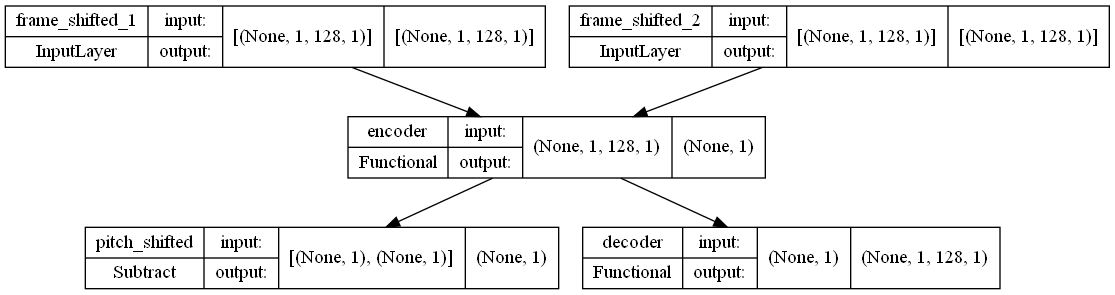

In [ ]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
# class DataLoader(Sequence):
#     """Generates data for Keras
#     Sequence based data generator. Suitable for building data generator for training and prediction.
#     """


#     def __init__(self, input_path, batch_size=64, shuffle=True):

#         """Initialization
#         :param x_set: array containing all the data points (cqt frames for all audio in our case)
#         :param batch_size: batch size at each iteration
#         :param shuffle: True to shuffle cqt frames indexes after every epoch
#         """
# #         # I concatenate all the CQT matrix (for all audios)
# #         CQT_frames = np.full([190, 1], None)
# #         count = 0
# #         for i, imitation_folder in enumerate([f for f in input_path.iterdir() if f.is_dir()]):
# #             if imitation_folder.is_dir():
# #                 for p in imitation_folder.glob("*.wav"):
# #                     count += 1
# #                     y, sr = librosa.load(p,sr=16000)
# #                     cqt = np.abs(librosa.cqt(y, sr=sr,hop_length=512,n_bins=190,bins_per_octave=24, window='hann'))
# #                     CQT_frames = np.concatenate((CQT_frames, cqt), axis=1)

# #         CQT_frames = np.delete(CQT_frames, 0, 1)
# #         CQT_frames_transp = CQT_frames.transpose()
# #         # total_times_audio = (CQT_frames.shape[1]-count) * 0.032
# #         # print("Nous avons environ " + str((int)(total_times_audio)) + " secondes d'audio")
# #         num_frames = CQT_frames_transp.shape[0]
# #         num_val = (int)(np.floor(num_frames*0.2))
# #         x_train = CQT_frames_transp[0:num_frames-num_val]
# #         x_val = CQT_frames_transp[num_frames-num_val:]

#         self.x_train = x_train
#         self.x_val = x_val
#         self.batch_size = batch_size
#         self.shuffle = shuffle
#         self.on_epoch_end()


#     def __len__(self):

#         """Denotes the number of batches per epoch
#         :return: number of batches per epoch
#         """
#         return math.ceil(len(self.x_train) / self.batch_size)

#     def num_batch_val(self):

#         """Denotes the number of batches per epoch for the validation
#         :return: number of batches per epoch
#         """
#         return math.ceil(len(self.x_val) / self.batch_size)


#     def __getitem__(self, idx):

#         """Generate one batch of data
#         :param idx: index of the batch
#         :return: X  when fitting.
#         """
#         batch_x = self.x_train[idx * self.batch_size:(idx + 1) * self.batch_size]
#         return np.array(batch_x)


#     def get_batch_val(self, idx):

#         """Generate one batch of  validation data
#         :param idx: index of the batch
#         :return: X  when evaluating.
#         """
#         batch_x = self.x_val[idx * self.batch_size:(idx + 1) * self.batch_size]
#         return np.array(batch_x)

# #     def __iter__(self):

# #     """Create a generator that iterate over the Sequence."""
# #         for item in (self[i] for i in range(len(self))):
# #           yield item

#     def on_epoch_end(self):

#         """
#         Updates indexes of cqt trame after each epoch
#         """
#         if self.shuffle:
#             np.random.shuffle(self.x_train)



In [ ]:

def dataLoader (input_path, batch_size = batch_size, shuffle = True):
        x_remaining = []
        x_remaining = np.array(x_remaining)
        total_batches = 0

        for k in range(1):
            for i, imitation_folder in enumerate([f for f in input_path.iterdir() if f.is_dir()]):
                if imitation_folder.is_dir():
                    for p in imitation_folder.glob("*.mp3"):
                        num_batches = 0
                        y, sr = librosa.load(p,sr=16000)
                        cqt = np.abs(librosa.cqt(y, sr=sr,hop_length=512,n_bins=190,bins_per_octave=24, window='hann'))
                        cqt_transp = cqt.transpose()

                        #  the CQT frames of the input audio tracks are shuffled,
                        # so that the frames in a batch are likely to come from different tracks.
                        if shuffle:
                            np.random.shuffle(cqt_transp)
                            #%%
                        if len(x_remaining) == 0 :
                             clone = cqt_transp
                        else:

                            cqt_transp = np.concatenate((x_remaining,cqt_transp), axis = 0)
                            clone = cqt_transp

                        # Case where the the number of frames cqt in the audio < batch_size
    #                   if len(cqt_transp) < batch_size :
    #                         x_remaining = cqt_transp
    #                         # read another audio and check again the total number of frames with the BatchSize
    #                         #(x_remaining+new_audio_frames)
    #                   else:
                        while len(cqt_transp) >= batch_size  :

                            num_batches += 1
                            x_batch = cqt_transp[:batch_size]
                            cqt_transp = cqt_transp[batch_size:]
                            x_frames_1 = []
                            x_frames_2 = []
                            pretex_label = []
                            for frame in x_batch:

                                """
                                the model samples at random two integer offsets kt,1 and kt,2 from a uniform distribution,
                                i.e., kt,i ∼ U(kmin, kmax), and it extracts two corresponding slices xt,1, xt,2 ∈ RF ,
                                spanning the range of CQT bins [kt,i, kt,i+F], i = 1, 2, F = 128
                                """

                                k1 = np.random.randint(kmin,kmax+1)
                                k2 = np.random.randint(kmin,kmax+1)
                                λk1 =(fbase)*2**(k1/Q)
                                λk2 =(fbase)*2**(k2/Q)
                                α = λk1 / λk2
                                delta_k = Q * np.log2(α)
                                p = σ * delta_k
                                pretex_label.append(p)
                                x1 =frame[k1 : k1 + F]
                                x1 = np.reshape(x1,(1,128,1)).astype('float32')
                                x_frames_1.append(x1)
                                x2 =frame[k2 : k2 + F]
                                x2 = np.reshape(x2,(1,128,1)).astype('float32')
                                x_frames_2.append(x2)

                                # %%%
                            yield  ([np.array(x_frames_1), np.array(x_frames_2)], [np.array(pretex_label).astype("float32"), np.array(x_frames_1), np.array(x_frames_2)])


                        total_batches += num_batches
                        num_frames = num_batches * batch_size
                        x_remaining = clone[num_frames:]
                        # read another audio and check again the total number of frames with the BatchSize
                        #(x_remaining+new_audio_frames)
            if len(x_remaining) != 0 :

                x_frames_1 = []
                x_frames_2 = []
                pretex_label = []
                for x in x_remaining :

                    k1 = np.random.randint(kmin,kmax+1)
                    k2 = np.random.randint(kmin,kmax+1)
                    λk1 =(fbase)*2**(k1/Q)
                    λk2 =(fbase)*2**(k2/Q)
                    α = λk1/λk2
                    delta_k = Q*np.log2(α)
                    p =σ*delta_k
                    pretex_label.append(p)
                    x1 =frame[k1 : k1 + F]
                    x1 = np.reshape(x1,(1,128,1)).astype('float32')
                    x_frames_1.append(x1)
                    x2 =frame[k2 : k2 + F]
                    x2 = np.reshape(x2,(1,128,1)).astype('float32')
                    x_frames_2.append(x2)

                    # %%%
                yield   ([np.array(x_frames_1), np.array(x_frames_2)], [np.array(pretex_label).astype("float32"), np.array(x_frames_1), np.array(x_frames_2)])
            print("total number of batches :", total_batches+1)






In [ ]:
train_path = Path("C:/Users/hp/anaconda3/test_model//")

In [ ]:
val_path = Path("C:/Users/hp/anaconda3/val_test_model//")

In [ ]:
#train = dataLoader(train_path)

#inputs,outputs = next(train)
#label = outputs[0]
#y_true = outputs[1]
#y_pred = outputs[2]
#diff = y_true-y_pred
#label.shape
#diff.shape
#y_true.shape

In [ ]:
# train = dataLoader(val_path)
# for inputs,outputs in train:
#     print(len(outputs))

In [ ]:
# y = tf.reshape(y_true,[64,128])
# y.shape

In [ ]:
# y_pred = tf.reshape(y_pred,[64,128])
# y_pred.shape

In [ ]:
# norm_euclid = tf.math.reduce_euclidean_norm((y_true-y_pred),axis=(-2,-1))
# norm_euclid.shape

In [ ]:
# mean = tf.reduce_mean(norm_euclid,axis=0)
# mean.numpy()

### Training

In [ ]:
# Custom loss for the reconstruction loss
def l_recons(x_1, x_recons_1):
   # x = tf.reshape(x_1,[64,128])
    #x_recons = tf.reshape(x_recons_1,[64,128])
    norm_euclid = tf.math.reduce_euclidean_norm((x_1-x_recons_1),axis=(-2,-1))
    return  tf.reduce_mean(norm_euclid,axis=0)

In [ ]:
# l = l_recons(y_true,y_pred)
# l

In [ ]:
# def l_recons1(x_1, x_recons_1):
#     x = tf.reshape(x_1,[64,128])
#     x_recons = tf.reshape(x_recons_1,[64,128])
#     norm_euclid = tf.math.reduce_euclidean_norm((x-x_recons),axis=1)
#     return  tf.reduce_mean(norm_euclid,axis=0)

In [ ]:
# l1 = l_recons1(y_true,y_pred)
# l1

In [ ]:
# Huber class test
loss_obj = tf.keras.losses.Huber(delta=τ,reduction=tf.keras.losses.Reduction.AUTO)
y_true = tf.constant([[1], [0],[2],[3]], dtype=tf.float32)
y_pred = tf.constant([[0.6], [0.4],[1],[0.5]], dtype=tf.float32)
# Using 'auto'/'sum_over_batch_size' reduction type.
h = loss_obj(y_true, y_pred)
h



<tf.Tensor: shape=(), dtype=float32, numpy=0.0014210828>

In [ ]:
# # Custom loss for the reconstruction loss
# def l_recons(x_1, x_recons_1):
#     squared_norm_difference = tf.square(tf.norm((x_1 - x_recons_1), ord='euclidean',axis=(-2,-1)))
#     return  tf.reduce_mean(squared_norm_difference,axis=0)

In [ ]:
# starter_learning_rate = 0.1
# end_learning_rate = 0.0001
# decay_steps = 1000
# learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
#     starter_learning_rate,
#     decay_steps,
#     end_learning_rate)

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate = 0.0001),
    loss=[keras.losses.Huber(delta=τ), l_recons, l_recons]
    ,
    loss_weights=[w_pitch, w_recons, w_recons],
    metrics=[keras.metrics.RootMeanSquaredError()]
)

In [ ]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

In [ ]:
import shutil

# shutil.rmtree(r'C:\Users\hp\anaconda3\notebooks\my_notebooks\logs\combined_loss')

In [ ]:
import datetime
log_dir = "logs/combined_loss/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
#### CALLBACKS
callbacks_list = [
                  #keras.callbacks.EarlyStopping(monitor='val_loss',patience=32),
                  #keras.callbacks.ModelCheckpoint(filepath='modelcheck.h5',monitor='val_loss',save_best_only=True),
                  keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
                  #keras.callbacks.ReduceLROnPlateau( monitor="val_loss",factor=0.1,patience=16,min_lr=0.0001)
                  ]

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
train_gen = dataLoader(train_path)
val_gen = dataLoader(val_path)

In [ ]:
# training with the built-in fit keras function
# The training is done on the cloud, it requires too many resources It does not fit on my local machine

  # history = model.fit(
  #     train_gen,
  #     epochs=100,
  #     callbacks=callbacks_list,
  #     validation_data=val_gen,
  #     steps_per_epoch=16000,
  #     validation_steps=512
  # )

In [ ]:
%tensorboard --logdir logs/combined_loss/fit

Reusing TensorBoard on port 6006 (pid 20096), started 1:13:43 ago. (Use '!kill 20096' to kill it.)

In [ ]:
# loss = history.history['pitch_shifted_loss']
# val_loss = history.history['val_pitch_shifted_loss']

# epochs = range(1, len(val_loss) +1)

# plt.plot(epochs,loss,'bo',label='Training loss')
# plt.plot(epochs,val_loss,'b',label='Validation loss')
# plt.title('Training and validation pitch_shifted_loss')
# plt.legend()

# plt.show()


In [ ]:
# loss = history.history['decoder_loss']
# val_loss = history.history['val_decoder_loss']

# epochs = range(1, len(val_loss) +1)

# plt.plot(epochs,loss,'bo',label='Training loss')
# plt.plot(epochs,val_loss,'b',label='Validation loss')
# plt.title('Training and validation decoder_loss(l_recons)')
# plt.legend()

# plt.show()


In [ ]:

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(1, len(val_loss) +1)

# plt.plot(epochs,loss,'bo',label='Training loss')
# plt.plot(epochs,val_loss,'b',label='Validation loss')
# plt.title('Training and validation resultant loss')
# plt.legend()

# plt.show()


In [ ]:
# for evaluation
# @tf.function
# def coef_determination_0(y, pred):
#     u =  tf.math.reduce_sum((y - pred)**2)
#     v = tf.math.reduce_sum((y - tf.math.reduce_mean(y))**2)
#     return 1 - u/v

In [ ]:
# for evaluation
# @tf.function
# def coef_determination(y, pred):
#     u =  tf.math.reduce_sum((y - pred)**2,axis=(0,1,2))
#     v = tf.math.reduce_sum((y - tf.math.reduce_mean(y,axis=0))**2,axis=(0,1,2))
#     return 1 - u/v

### Speeding-up your training step with tf.function
The default runtime in TensorFlow 2 is eager execution. As such, our training loop above executes eagerly.

This is great for debugging, but graph compilation has a definite performance advantage.
Describing your computation as a static graph enables the framework to apply global performance optimizations.
We can compile into a static graph any function that takes tensors as input. Just add a @tf.function decorator on it

In [ ]:
# # Instantiate an optimizer to train the model.
# optimizer = keras.optimizers.Adam(learning_rate=1e-4)
# # Instantiate a loss function.
# loss_fn = keras.losses.Huber(delta=τ)


In [ ]:
# # Prepare the metrics.
# train_mse_metric = keras.metrics.MeanSquaredError()
# val_mse_metric = keras.metrics.MeanSquaredError()

In [ ]:
# tf graph
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        pred_values = model(x, training=True)
        loss_value = loss_fn(y, pred_values)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_mse_metric.update_state(y, pred_values)
    #tf.print("TF-PRINT: ", loss_value)
    return loss_value

In [ ]:
@tf.function
def test_step(x, y):
    vals = model(x, training=False)
    val_mse_metric.update_state(y, vals)

In [ ]:
# Writting a training loop from scratch using tf.GradientTape

# import time
# # %%%
# epochs = 4
# for epoch in range(epochs):
#     train_gen = dataLoader(train_path)
#     val_gen = dataLoader(val_path)
#     print("\nStart of epoch %d" % (epoch,))
#     start_time = time.time()

#     # Iterate over the batches of the dataset.
#     for step, (l, pretex_label) in enumerate(train_gen) :
#         loss_value = train_step(l, pretex_label)

#         # Log every 200 batches.
#         if step % 100 == 0:
#             print(
#                 "Training loss  (for one batch) at step %d: "
#                 % (step)
#             )
#             tf.print("LOSS: ", loss_value)
#
#             print("Seen so far: %d samples" % ((step + 1) * batch_size))

#     # Display metrics at the end of each epoch.
#     train_mae = train_mae_metric.result()
#     tf.print("Training mae over epoch: ", train_mae)
#     #print("Training mse over epoch: %.4f" % (float(train_mse),))

#     # Reset training metrics at the end of each epoch
#     train_mae_metric.reset_states()

#     # Run a validation loop at the end of each epoch.
#     for step, (l, pretex_label) in enumerate(val_gen) :
#         test_step(l, pretex_label)

#     val_mae = val_mae_metric.result()
#     tf.print("Validation mae over epoch : ", val_mae)
#    # print("Validation mse: %.4f" % (float(val_mse),))
#     print("Time taken: %.2fs" % (time.time() - start_time))
#     val_mae_metric.reset_states()
# #     print("Validation mse: %.4f" % (float(val_mse),))
# #     print("Time taken: %.2fs" % (time.time() - start_time))

In [ ]:
# %%%

In [ ]:
# # Define our metrics
# train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
# val_loss = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)

In [ ]:
# def train_step(model, optimizer, x_train, y_train):
#     with tf.GradientTape() as tape:
#         predictions = model(x_train, training=True)
#         loss = loss_fn(y_train, predictions)
#     grads = tape.gradient(loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(grads, model.trainable_variables))

#     train_loss(loss)
#     train_mse_metric.update_state(y_train, predictions)

In [ ]:
# def eval_step(model, x_test, y_test):
#     predictions = model(x_test,training = False)
#     loss = loss_fn(y_test, predictions)

#     val_loss(loss)
#     val_mse_metric.update_state(y_test, predictions)

In [ ]:
# import datetime
# current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# train_log_dir = 'logs/gradient_tape/' + current_time + '/training'
# val_log_dir = 'logs/gradient_tape/' + current_time + '/validation'
# train_summary_writer = tf.summary.create_file_writer(train_log_dir)
# val_summary_writer = tf.summary.create_file_writer(val_log_dir)

In [ ]:
# Other training loop
# EPOCHS = 8

# for epoch in range(EPOCHS):

#     train_gen = dataLoader(train_path)
#     val_gen = dataLoader(val_path)
#     print("\nStart of epoch %d" % (epoch,))
#     start_time = time.time()

#     for (x_train, y_train) in train_gen:
#         train_step(model, optimizer, x_train, y_train)
#         with train_summary_writer.as_default():
#             tf.summary.scalar('Loss', train_loss.result(), step=epoch)
#             tf.summary.scalar('Metric_MSE', train_mse_metric.result(), step=epoch)

#     for (x_val, y_val) in val_gen:
#         eval_step(model, x_val, y_val)
#         with val_summary_writer.as_default():
#             tf.summary.scalar('Loss', val_loss.result(), step=epoch)
#             tf.summary.scalar('Metric_MSE', val_mse_metric.result(), step=epoch)

#     template = 'Loss: {}, MSE: {}, Val Loss: {}, Val_MSE: {}'
#     print (template.format(
#                          train_loss.result(),
#                          train_mse_metric.result(),
#                          val_loss.result(),
#                          val_mse_metric.result()))

#     # Reset metrics every epoch
#     train_loss.reset_states()
#     val_loss.reset_states()
#     train_mse_metric.reset_states()
#     val_mse_metric.reset_states()
#     print("Time taken: %.2fs" % (time.time() - start_time))

In [ ]:
# def fit(x, y, batch_size, epochs):
#     for epoch in range(epochs):
#         for batch_x, batch_y in batch(x, y, batch_size):
#             model.train_on_batch(batch_x, batch_y)

Sorry but I can't tell you more about the results obtained because the company (my internship master) asked me to keep them secret (confidential). By the way the first release of the application (the holy quran imitation plateform) should be out soon.